In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab9
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

# Other imports
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.ticker import MaxNLocator
import numpy as np
import math
import sys

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera, RadioMaterial, LambertianPattern, watt_to_dbm
from sionna.mapping import Constellation, Mapper, Demapper
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.utils import BinarySource, ebnodb2no, sim_ber
from sionna.channel import AWGN
from sionna.ofdm import ResourceGrid

In [2]:
scene = load_scene("blender/scene.xml")

In [3]:
polycarbonate = RadioMaterial("polycarbonate",
                              relative_permittivity=3,
                              conductivity=0.001,
                              scattering_coefficient=0.3,
                              xpd_coefficient=0.1,
                              scattering_pattern=LambertianPattern())

cardboard  = RadioMaterial("cardboard",
                           relative_permittivity=2.3,
                           conductivity=0.001,
                           scattering_coefficient=0.3,
                           xpd_coefficient=0.1,
                           scattering_pattern=LambertianPattern())

plastic = RadioMaterial("plastic",
                        relative_permittivity=2.8,
                        conductivity=0.0001,
                        scattering_coefficient=0.3,
                        xpd_coefficient=0.1,
                        scattering_pattern=LambertianPattern())

ceramic  = RadioMaterial("ceramic",
                         relative_permittivity=6,
                         conductivity=0.0001,
                         scattering_coefficient=0.3,
                         xpd_coefficient=0.1,
                         scattering_pattern=LambertianPattern())

In [4]:
Polycarbonate_parts = scene.get("Polycarbonate_parts")
Paper_boxes = scene.get("Paper_boxes") 
Plastic_parts = scene.get("Plastic_parts")  
Ceramic_parts = scene.get("Ceramic_parts")

In [5]:
Polycarbonate_parts.radio_material = polycarbonate 
Paper_boxes.radio_material = cardboard 
Plastic_parts.radio_material = plastic 
Ceramic_parts.radio_material = ceramic

In [6]:
scene.frequency = 60.48e9 # in Hz; implicitly updates RadioMaterials
scene.bandwidth = 512e6
scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

In [7]:
print(f"Bandwidth: ", scene.bandwidth.numpy(), "[Hz]")
print(f"Temperature: ", scene.temperature.numpy(), "[K]")
print(f"Thermal noise power: ", watt_to_dbm(scene.thermal_noise_power).numpy(), "[dBm]")

Bandwidth:  512000000.0 [Hz]
Temperature:  293.0 [K]
Thermal noise power:  -86.83778 [dBm]


In [8]:
def angles(impulse_response, path_idx, angle_idx):
    if impulse_response[path_idx][angle_idx] < 0:
        impulse_response[path_idx][angle_idx] = 360 + impulse_response[path_idx][angle_idx]
        
    if impulse_response[path_idx][angle_idx] == 360:
        impulse_response[path_idx][angle_idx] = 0

In [9]:
def noise_CIR(tx_position, tx_power, filename):

    scene.remove("tx")
    scene.remove("tx_noise")
    scene.remove("rx")
    
    # Configure antenna array for all transmitters
    scene.tx_array = PlanarArray(num_rows=1,
                                 num_cols=1,
                                 vertical_spacing=0.1,
                                 horizontal_spacing=0.1,
                                 pattern="tr38901",
                                 polarization="H")

    # Configure antenna array for all receivers
    scene.rx_array = PlanarArray(num_rows=1, 
                                 num_cols=1, 
                                 vertical_spacing=0.1,
                                 horizontal_spacing=0.1,
                                 pattern="tr38901",
                                 polarization="H")

    # Create transmitter
    tx = Transmitter(name="tx",
                     color=tf.Variable((1, 0, 0), dtype=tf.float32),
                     position=tx_position,
                     orientation=tf.Variable([0,0,0], dtype=tf.float32))

    # Create a receiver
    rx = Receiver(name="rx",
                  color=tf.Variable((1, 0, 0), dtype=tf.float32),
                  position=tf.Variable([4.2,2.5,1], dtype=tf.float32),
                  orientation=tf.Variable([0,0,0], dtype=tf.float32))

    # Add transmitter instance to scene
    scene.add(tx)

    # Add receiver instance to scene
    scene.add(rx)

    tx.look_at(rx) 
    rx.look_at(tx) 

    tx.power_dbm = tx_power

    paths = scene.compute_paths(max_depth=5,
                                num_samples=1e6)  
    
    paths.normalize_delays = False
    a, tau = paths.cir()
    all_paths = tau.shape[3]

    impulse_response = np.zeros((all_paths, 7))

    unit = 1 # 0 = rad, 1 = degree 

    for path_idx in range(all_paths):
        impulse_response[path_idx][0] = path_idx                                              # Path index
        impulse_response[path_idx][1] = np.abs(paths.a[0,0,0,0,0,path_idx, 0].numpy())        # Channel coefficient
        impulse_response[path_idx][2] = paths.tau[0,0,0,path_idx].numpy()                     # Propagation delay [s]
    
        if unit == 0:
            impulse_response[path_idx][3] = paths.theta_t[0,0,0,path_idx].numpy()             # Zenith angle of departure [rad]
            impulse_response[path_idx][4] = paths.phi_t[0,0,0,path_idx].numpy()               # Azimuth angle of departure [rad]
            impulse_response[path_idx][5] = paths.theta_r[0,0,0,path_idx].numpy()             # Zenith angle of arrival [rad]
            impulse_response[path_idx][6] = paths.phi_r[0,0,0,path_idx].numpy()               # Azimuth angle of arrival [rad]
            
        elif unit == 1:
            impulse_response[path_idx][3] = round(paths.theta_t[0,0,0,path_idx].numpy()*180/math.pi) # Zenith angle of departure [°]
            impulse_response[path_idx][4] = round(paths.phi_t[0,0,0,path_idx].numpy()*180/math.pi)   # Azimuth angle of departure [°]
            impulse_response[path_idx][5] = round(paths.theta_r[0,0,0,path_idx].numpy()*180/math.pi) # Zenith angle of arrival [°]
            impulse_response[path_idx][6] = round(paths.phi_r[0,0,0,path_idx].numpy()*180/math.pi)   # Azimuth angle of arrival [°]

        angles(impulse_response, path_idx, 3)
        angles(impulse_response, path_idx, 4)
        angles(impulse_response, path_idx, 5)
        angles(impulse_response, path_idx, 6)
    
    np.save(filename, impulse_response)

In [73]:
noise_CIR([6.1,2.5,1], 42, 'data/noise_simulation/tx.npy') # TX position
noise_CIR([8.9,4.8,1], 42, 'data/noise_simulation/noise1.npy') # noise position

In [74]:
CIR_TX = np.load('data/noise_simulation/tx.npy')
CIR_noise = np.load('data/noise_simulation/noise1.npy')

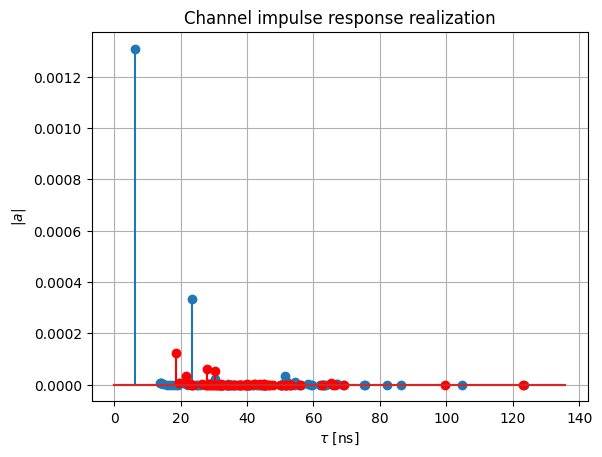

In [75]:
t = CIR_TX[:,2]/1e-9 # Scale to ns
a_abs = CIR_TX[:,1]
t = np.concatenate([(0.,), t, (np.max(t)*1.1,)])
a_abs = np.concatenate([(np.nan,), a_abs, (np.nan,)])

t_noise = CIR_noise[:,2]/1e-9 # Scale to ns
a_abs_noise = CIR_noise[:,1]
t_noise = np.concatenate([(0.,), t_noise, (np.max(t_noise)*1.1,)])
a_abs_noise = np.concatenate([(np.nan,), a_abs_noise, (np.nan,)])

# And plot the CIR
plt.figure()
plt.title("Channel impulse response realization")

plt.stem(t, a_abs)
plt.stem(t_noise, a_abs_noise,'r')
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");
plt.grid()

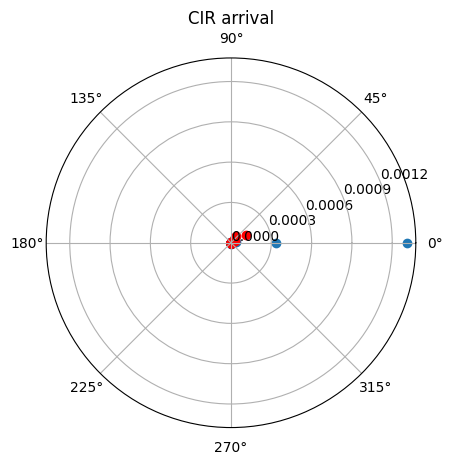

In [76]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.scatter(CIR_TX[:,6]*np.pi/180, CIR_TX[:,1])
ax.scatter(CIR_noise[:,6]*np.pi/180, CIR_noise[:,1], color='red')
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

ax.set_title("CIR arrival")
ax.grid(True)
plt.show()

In [77]:
class System_Model(tf.keras.Model):
    """System model for channel coding BER simulations.

    This model allows to simulate BERs over an AWGN channel with
    QAM modulation. Arbitrary FEC encoder/decoder layers can be used to
    initialize the model.

    Parameters
    ----------
        k: int
            number of information bits per codeword.

        n: int
            codeword length.

        num_bits_per_symbol: int
            number of bits per QAM symbol.

        encoder: Keras layer
            A Keras layer that encodes information bit tensors.

        decoder: Keras layer
            A Keras layer that decodes llr tensors.

        demapping_method: str
            A string denoting the demapping method. Can be either "app" or "maxlog".

        sim_esno: bool
            A boolean defaults to False. If true, no rate-adjustment is done for the SNR calculation.

         cw_estiamtes: bool
            A boolean defaults to False. If true, codewords instead of information estimates are returned.
    Input
    -----
        batch_size: int or tf.int
            The batch_size used for the simulation.

        ebno_db: float or tf.float
            A float defining the simulation SNR.

    Output
    ------
        (u, u_hat):
            Tuple:

        u: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the transmitted information bits.

        u_hat: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the estimated information bits.
    """
    def __init__(self,
                 k,
                 n,
                 num_bits_per_symbol,
                 subcarrier_spacing,
                 a_abs,
                 a_abs_noise,
                 noise_sweep,
                 noise_amp):

        super().__init__()

        # number of bit per QAM symbol
        self.num_bits_per_symbol = num_bits_per_symbol
        
        # store values internally
        # Transport block Config
        if self.num_bits_per_symbol == 2: # QPSK
            self.k = 449
        elif self.num_bits_per_symbol == 4: # 16QAM
            self.k = k
        elif self.num_bits_per_symbol == 6: # 64QAM
            self.k = 466*2
        elif self.num_bits_per_symbol == 8: # 256QAM
            self.k = 711
        elif self.num_bits_per_symbol == 10: # 1024QAM
            self.k = 853*2

        self.subcarrier_spacing = subcarrier_spacing
        self.n = n

        # noise
        self.a_abs = a_abs
        self.a_abs_noise = a_abs_noise
        self.noise_sweep = noise_sweep
        self.noise_amp = noise_amp
        self.R = 100
        
        # init components
        self.source = BinarySource()

        # initialize mapper and demapper for constellation object
        self.constellation = Constellation("qam",
                                num_bits_per_symbol=self.num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper("app",
                                 constellation=self.constellation)

        # the channel can be replaced by more sophisticated models
        self.channel = AWGN()

        # FEC encoder / decoder
        self.encoder = LDPC5GEncoder(k=self.k, n=self.n)
        self.decoder = LDPC5GDecoder(self.encoder, num_iter=10)

        self.rg = ResourceGrid(num_ofdm_symbols = 14,
                               fft_size = 48,
                               subcarrier_spacing = self.subcarrier_spacing,
                               num_tx = 1,
                               num_streams_per_tx = 1,
                               pilot_pattern = "kronecker",
                               pilot_ofdm_symbol_indices = [2,5,8,11])

    @tf.function() # enable graph mode for increased throughputs
    def call(self, batch_size, ebno_db):

        
        no = ebnodb2no(ebno_db,
                        num_bits_per_symbol=self.num_bits_per_symbol,
                        coderate=self.k/self.n,
                        resource_grid=self.rg)

        u = self.source([batch_size, self.k]) # generate random data
        u_noise = self.source([batch_size, self.k]) # generate random data
        
        c = self.encoder(u) # explicitly encode
        c_noise = self.encoder(u_noise) # explicitly encode

        x = self.mapper(c) # map c to symbols x
        x_noise = self.mapper(c_noise) # map c to symbols x
        
        if self.noise_sweep == True:
            sig = x+self.noise_amp*x_noise
        else:
            data_amplitude = np.sqrt(self.a_abs*self.R)
            noise_amplitude = np.sqrt(self.a_abs_noise*self.R)

            if data_amplitude > noise_amplitude:
                normalize_amp = data_amplitude
            else:
                normalize_amp = noise_amplitude
            
            sig = (data_amplitude/normalize_amp)*x+(noise_amplitude/normalize_amp)*x_noise
    
        
        y = self.channel([sig, no]) # transmit over AWGN channel

        llr_ch = self.demapper([y, no]) # demap y to LLRs

        u_hat = self.decoder(llr_ch) # run FEC decoder (incl. rate-recovery)

        return u, u_hat

In [78]:
n_bits_per_symbol = [2,4,6,8,10]
subcarrier_spacing = [15e3,120e3,480e3,960e3]
k = [378, 490, 616]
noise_amp = [0.01, 0.1, 0.25, 0.5, 1] 
batch_size = 128
ebno_db = np.linspace(-10, 30, num=81)

BER1 = []
BER2 = []
BER3 = []
BER4 = []

In [79]:
# run ber simulations for each code we have added to the list
for num_bits_per_symbol in n_bits_per_symbol:

    if num_bits_per_symbol == 2 or num_bits_per_symbol == 4 or num_bits_per_symbol == 8:
        n = 1024
    elif num_bits_per_symbol == 6:
        n = 2046
    elif num_bits_per_symbol == 10:
        n = 2040
        
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k[0],
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         subcarrier_spacing=subcarrier_spacing[1],
                         a_abs=max(CIR_TX[:,1]),
                         a_abs_noise=max(CIR_noise[:,1]),
                         noise_sweep = False,
                         noise_amp = noise_amp[0])

    ber, bler = sim_ber(model,
                        ebno_db,
                        batch_size=batch_size,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    BER1.append(list(ber.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 4.2618e-01 | 1.0000e+00 |       48987 |      114944 |          256 |         256 |         0.9 |reached target block errors
     -9.5 | 4.2093e-01 | 1.0000e+00 |       48383 |      114944 |          256 |         256 |         0.2 |reached target block errors
     -9.0 | 4.1702e-01 | 1.0000e+00 |       47934 |      114944 |          256 |         256 |         0.2 |reached target block errors
     -8.5 | 4.0891e-01 | 1.0000e+00 |       47002 |      114944 |          256 |         256 |         0.2 |reached target block errors
     -8.0 | 4.0789e-01 | 1.0000e+00 |       46884 |      114944 |          256 |         256 |         0.2 |reached target block errors
     -7.5 | 4.0146e-01 | 1.0000e+00 |       46145 |      114944 |

In [80]:
for spacing in subcarrier_spacing:
    
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k[0],
                         n=1024,
                         num_bits_per_symbol=n_bits_per_symbol[1],
                         subcarrier_spacing=spacing,
                         a_abs=max(CIR_TX[:,1]),
                         a_abs_noise=max(CIR_noise[:,1]),
                         noise_sweep = False,
                         noise_amp = noise_amp[0])

    ber, bler = sim_ber(model,
                        ebno_db,
                        batch_size=128,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    BER2.append(list(ber.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 4.5014e-01 | 1.0000e+00 |       43559 |       96768 |          256 |         256 |         0.9 |reached target block errors
     -9.5 | 4.4666e-01 | 1.0000e+00 |       43222 |       96768 |          256 |         256 |         0.2 |reached target block errors
     -9.0 | 4.4289e-01 | 1.0000e+00 |       42858 |       96768 |          256 |         256 |         0.2 |reached target block errors
     -8.5 | 4.3987e-01 | 1.0000e+00 |       42565 |       96768 |          256 |         256 |         0.2 |reached target block errors
     -8.0 | 4.3307e-01 | 1.0000e+00 |       41907 |       96768 |          256 |         256 |         0.2 |reached target block errors
     -7.5 | 4.3224e-01 | 1.0000e+00 |       41827 |       96768 |

In [81]:
for k2 in k:
    
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k2,
                         n=1024,
                         num_bits_per_symbol=n_bits_per_symbol[1],
                         subcarrier_spacing=subcarrier_spacing[1],
                         a_abs=max(CIR_TX[:,1]),
                         a_abs_noise=max(CIR_noise[:,1]),
                         noise_sweep = False,
                         noise_amp = noise_amp[0])

    ber, bler = sim_ber(model,
                        ebno_db,
                        batch_size=128,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    BER3.append(list(ber.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 4.5072e-01 | 1.0000e+00 |       43615 |       96768 |          256 |         256 |         0.9 |reached target block errors
     -9.5 | 4.4612e-01 | 1.0000e+00 |       43170 |       96768 |          256 |         256 |         0.2 |reached target block errors
     -9.0 | 4.4408e-01 | 1.0000e+00 |       42973 |       96768 |          256 |         256 |         0.2 |reached target block errors
     -8.5 | 4.4021e-01 | 1.0000e+00 |       42598 |       96768 |          256 |         256 |         0.2 |reached target block errors
     -8.0 | 4.3545e-01 | 1.0000e+00 |       42138 |       96768 |          256 |         256 |         0.2 |reached target block errors
     -7.5 | 4.2928e-01 | 1.0000e+00 |       41541 |       96768 |

In [82]:
for noise_ampl in noise_amp:
    
    # generate a new model with the given encoder/decoder
    model = System_Model(k=k[0],
                         n=1024,
                         num_bits_per_symbol=n_bits_per_symbol[1],
                         subcarrier_spacing=subcarrier_spacing[1],
                         a_abs=max(CIR_TX[:,1]),
                         a_abs_noise=max(CIR_noise[:,1]),
                         noise_sweep = True,
                         noise_amp = noise_ampl)

    ber, bler = sim_ber(model,
                        ebno_db,
                        batch_size=128,
                        max_mc_iter=10,
                        num_target_block_errors=200)
    
    BER4.append(list(ber.numpy()))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 4.5109e-01 | 1.0000e+00 |       43651 |       96768 |          256 |         256 |         0.9 |reached target block errors
     -9.5 | 4.4438e-01 | 1.0000e+00 |       43002 |       96768 |          256 |         256 |         0.2 |reached target block errors
     -9.0 | 4.3933e-01 | 1.0000e+00 |       42513 |       96768 |          256 |         256 |         0.2 |reached target block errors
     -8.5 | 4.3802e-01 | 1.0000e+00 |       42386 |       96768 |          256 |         256 |         0.2 |reached target block errors
     -8.0 | 4.3422e-01 | 1.0000e+00 |       42019 |       96768 |          256 |         256 |         0.2 |reached target block errors
     -7.5 | 4.3200e-01 | 1.0000e+00 |       41804 |       96768 |

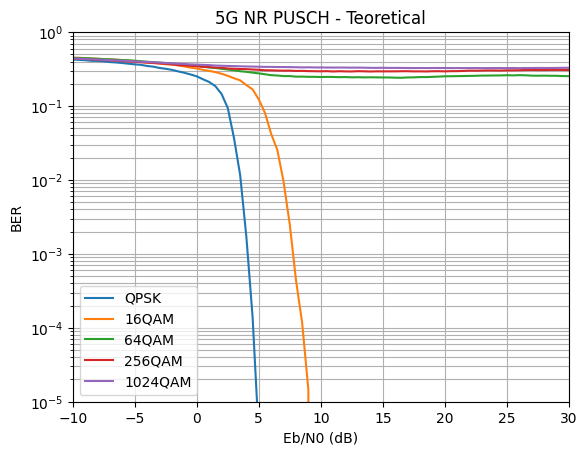

In [83]:
plt.figure()
plt.title("5G NR PUSCH - Teoretical")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([ebno_db[0], ebno_db[-1]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for num_bits_per_symbol in n_bits_per_symbol:
    
    plt.semilogy(ebno_db, BER1[i])

    if num_bits_per_symbol == 2:
        legend.append("QPSK")
    else:
        legend.append(str(2 ** num_bits_per_symbol) + "QAM")

    i += 1
    
plt.legend(legend);

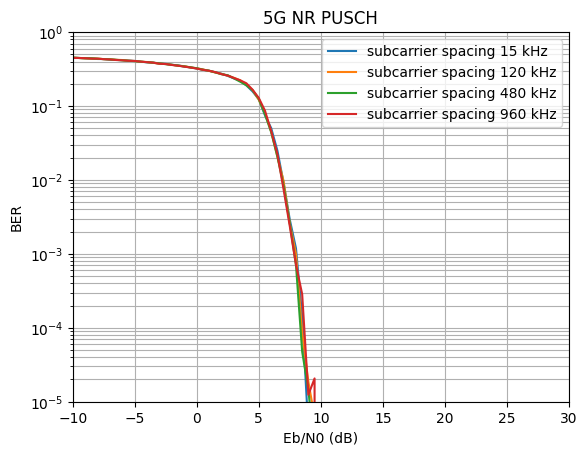

In [84]:
plt.figure()
plt.title("5G NR PUSCH")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([ebno_db[0], ebno_db[-1]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for spacing in subcarrier_spacing:
    
    plt.semilogy(ebno_db, BER2[i])
    legend.append("subcarrier spacing " + str(int(spacing/1000)) + " kHz" )
    i += 1
   
plt.legend(legend);

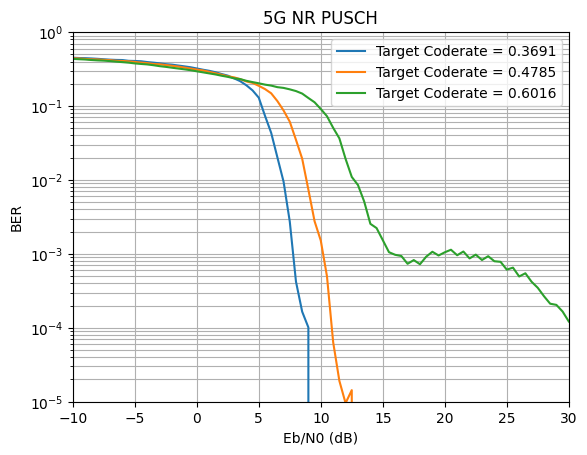

In [85]:
plt.figure()
plt.title("5G NR PUSCH")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([ebno_db[0], ebno_db[-1]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for k2 in k:
    
    plt.semilogy(ebno_db, BER3[i])
    cr = k2/1024
    legend.append("Target Coderate = " + str('%.4f' % cr))
    i += 1
   
plt.legend(legend);

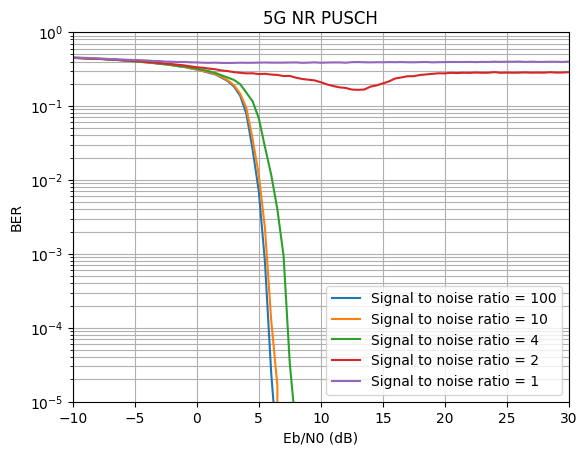

In [88]:
plt.figure()
plt.title("5G NR PUSCH")
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.grid(which="both")
plt.xlim([ebno_db[0], ebno_db[-1]])
plt.ylim([1e-5, 1.0])

i = 0
legend = []

for noise_ampl in noise_amp:
    
    plt.semilogy(ebno_db, BER4[i])
    legend.append("Signal to noise ratio = " + str('%.0f' % (1/noise_ampl)))
    i += 1
   
plt.legend(legend);

In [ ]:
def coverage_map_fnc(tx_position, noise_position, tx_orientation, noise_orientation, pattern, tx_power, noise_power, cm_height): 

    scene.remove("tx")
    scene.remove("tx_noise")
    scene.remove("rx")
    
    # Configure antenna array for all transmitters
    scene.tx_array = PlanarArray(num_rows=1, #16
                             num_cols=1, #4
                             vertical_spacing=0.1,
                             horizontal_spacing=0.1,
                             pattern=pattern,
                             polarization="H")

    # Configure antenna array for all receivers
    scene.rx_array = PlanarArray(num_rows=1, #16
                             num_cols=1, #16
                             vertical_spacing=0.1,
                             horizontal_spacing=0.1,
                             pattern=pattern,
                             polarization="H")

    # Create transmitter
    tx = Transmitter(name="tx",
                 color=tf.Variable((1, 0, 0), dtype=tf.float32),
                 position=tx_position, 
                 orientation=tf.Variable([0,0,0], dtype=tf.float32))

    # Create noise transmitter
    tx_noise = Transmitter(name="tx_noise",
                 color=tf.Variable((0, 0, 1), dtype=tf.float32),
                 position=noise_position, 
                 orientation=tf.Variable([0,0,0], dtype=tf.float32))
    
    # Create a receiver
    rx = Receiver(name="rx",
              color=tf.Variable((1, 0, 0), dtype=tf.float32),
              position=tf.Variable([6.4,3,1], dtype=tf.float32),
              orientation=tf.Variable([0,0,0], dtype=tf.float32))
    
    # Add transmitter instances to scene
    scene.add(tx)
    scene.add(tx_noise)

    # Add receiver instance to scene
    scene.add(rx)

    tx.look_at(tx_orientation) 
    tx_noise.look_at(noise_orientation) 
    rx.look_at(tx) 

    tx.power_dbm = tx_power
    tx_noise.power_dbm = noise_power
    
    # Compute coverage map
    cm = scene.coverage_map(max_depth=5,           # Maximum number of ray scene interactions
                        num_samples=int(10e6), # If you increase: less noise, but more memory required
                        cm_cell_size=(0.1, 0.1),   # Resolution of the coverage map
                        cm_center=[5,2.5, cm_height],   # Center of the coverage map
                        cm_size=[11,6],    # Total size of the coverage map
                        cm_orientation=[0, 0, 0]) # Orientation of the coverage map, e.g., could be also vertical
    
    return cm

In [ ]:
cm1 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [6.4,3,1], 
                      noise_orientation = [6.4,3,1],
                      pattern = "iso", 
                      tx_power = 40, 
                      noise_power = 40, 
                      cm_height = 1)

cm1.show(metric="sinr", tx=0);
cm1.show_association("rss");

In [ ]:
cm2 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [6.4,3,1], 
                      noise_orientation = [6.4,3,1],
                      pattern = "iso", 
                      tx_power = 40, 
                      noise_power = 60, 
                      cm_height = 1)

cm2.show(metric="sinr", tx=0);
cm2.show_association("rss");

In [ ]:
cm3 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [6.4,3,1], 
                      noise_orientation = [6.4,3,1],
                      pattern = "iso", 
                      tx_power = 40, 
                      noise_power = 50, 
                      cm_height = 1)

cm3.show(metric="sinr", tx=0);
cm3.show_association("rss");

In [ ]:
cm4 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [6.4,3,1], 
                      noise_orientation = [6.4,3,1],
                      pattern = "iso", 
                      tx_power = 40, 
                      noise_power = 30, 
                      cm_height = 1)

cm4.show(metric="sinr", tx=0);
cm4.show_association("rss");

In [ ]:
cm5 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [6.4,3,1], 
                      noise_orientation = [6.4,3,1],
                      pattern = "iso", 
                      tx_power = 40, 
                      noise_power = 20, 
                      cm_height = 1)

cm5.show(metric="sinr", tx=0);
cm5.show_association("rss");

Position

In [ ]:
cm6 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [6.4,3,1], 
                      tx_orientation = [6.4,3,1], 
                      noise_orientation = [6.4,3,1],
                      pattern = "iso", 
                      tx_power = 40, 
                      noise_power = 40, 
                      cm_height = 1)

cm6.show(metric="sinr", tx=0);
cm6.show_association("rss");

In [ ]:
cm7 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [10,0.6,2.5], 
                      tx_orientation = [6.4,3,1], 
                      noise_orientation = [6.4,3,1],
                      pattern = "iso", 
                      tx_power = 40, 
                      noise_power = 40, 
                      cm_height = 1)

cm7.show(metric="sinr", tx=0);
cm7.show_association("rss");

Orientation

In [ ]:
cm8 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [2,2.8,1], 
                      noise_orientation = [6.8,3.5,1],
                      pattern = "tr38901", 
                      tx_power = 40, 
                      noise_power = 40, 
                      cm_height = 1)

cm8.show(metric="sinr", tx=0);
cm8.show_association("rss");

In [ ]:
cm9 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [2,4,1], 
                      noise_orientation = [6.8,3.5,1],
                      pattern = "tr38901", 
                      tx_power = 40, 
                      noise_power = 40, 
                      cm_height = 1)

cm9.show(metric="sinr", tx=0);
cm9.show_association("rss");

In [ ]:
cm10 = coverage_map_fnc(tx_position = [0.8,2.8,1], 
                      noise_position = [8.4,4.5,1], 
                      tx_orientation = [2,1.6,1], 
                      noise_orientation = [6.8,3.5,1],
                      pattern = "tr38901", 
                      tx_power = 40, 
                      noise_power = 40, 
                      cm_height = 1)

cm10.show(metric="sinr", tx=0);
cm10.show_association("rss");